# Training agent using DDPG

Model-free, off-policy RL method.

Two networks here:
 - Actor: Proposes an action
 - Critic: Evaluates action based on new state, reward

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [3]:
# Experience Replay

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [4]:
# Here we define the Actor and Critic networks. 

def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="relu")(inputs)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1, activation="sigmoid", kernel_initializer=last_init)(out)

    # Our upper bound is 10.0 for x.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(256, activation="relu")(concat)
    out = layers.Dense(256, activation="relu")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [5]:
# Returns an action sampled from our Actor network plus some noise for exploration.
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.asarray([np.squeeze(legal_action)])

## Training hyperparameters

In [6]:
from data_prep import DataPrep
from env import CMAPSSEnv
from VAE_dense import VAE


file_path = "CMAPSSData/train_FD002.txt"
num_settings = 3
num_sensors = 21
num_units = 40
prev_step_units = 200
step = "RL"

neurons = [64, 32, 16, 8]

# Data prep
data = DataPrep(file=file_path,
                num_settings=num_settings, 
                num_sensors=num_sensors, 
                num_units=num_units, 
                prev_step_units=prev_step_units,
                step=step,
                normalization_type="01")

df = data.ReadData()

In [7]:
# List of engine lifetimes
engine_lives = df.groupby(df['Unit']).size().tolist()
num_engines = len(engine_lives)

# Load decoder
vae = VAE(latent_dim=1,image_size=25)

##########################################
env_config = {
    "df": df,
    "timestep": 0,
    "obs_size": num_settings+num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": vae.load_models(),
}

env = CMAPSSEnv(**env_config)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print(upper_bound, lower_bound)

2022-04-19 16:38:26.905685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-19 16:38:27.145718: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://f324c84c-61b4-46c4-b237-b4d5d4ae3315/assets
Size of State Space ->  25
Size of Action Space ->  1
10.0 0.0


In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 1000
# Discount factor for future rewards
gamma = 0.9
# Used to update target networks
tau = 0.01

buffer = Buffer(50000, 64)

In [9]:
# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

for ep in range(total_episodes):

    prev_state = env.reset()
    episodic_reward = 0

    for timestep in range(np.sum(engine_lives)):

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

        action = policy(tf_prev_state, ou_noise)
        # Receive state and reward from environment.
        state, reward, done, _ = env.step(action)

        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)

        # End this episode when `done` is True
        if done:
            break

        prev_state = state

    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)

Episode * 0 * Avg Reward is ==> -3273.6441345529097
Episode * 1 * Avg Reward is ==> -3208.99332850488
Episode * 2 * Avg Reward is ==> -3201.132169944153
Episode * 3 * Avg Reward is ==> -3079.371993042195
Episode * 4 * Avg Reward is ==> -3049.5687810539284
Episode * 5 * Avg Reward is ==> -2994.80419521634
Episode * 6 * Avg Reward is ==> -2964.3057482850977
Episode * 7 * Avg Reward is ==> -2986.3344713301985
Episode * 8 * Avg Reward is ==> -2966.514041770625
Episode * 9 * Avg Reward is ==> -2941.713234532875
Episode * 10 * Avg Reward is ==> -2941.237260493905
Episode * 11 * Avg Reward is ==> -2935.972045667479
Episode * 12 * Avg Reward is ==> -2930.2250893395617
Episode * 13 * Avg Reward is ==> -2906.922815960217
Episode * 14 * Avg Reward is ==> -2914.118088663169
Episode * 15 * Avg Reward is ==> -2906.2874467665515
Episode * 16 * Avg Reward is ==> -2905.840909502558
Episode * 17 * Avg Reward is ==> -2896.1807137528463
Episode * 18 * Avg Reward is ==> -2903.8082137919087
Episode * 19 * A

Episode * 156 * Avg Reward is ==> -2804.618068030941
Episode * 157 * Avg Reward is ==> -2804.7435556063115
Episode * 158 * Avg Reward is ==> -2812.3738315113965
Episode * 159 * Avg Reward is ==> -2816.5232866653178
Episode * 160 * Avg Reward is ==> -2830.828019737209
Episode * 161 * Avg Reward is ==> -2828.1313155908865
Episode * 162 * Avg Reward is ==> -2830.1882890486427
Episode * 163 * Avg Reward is ==> -2831.546434482351
Episode * 164 * Avg Reward is ==> -2828.2246855553
Episode * 165 * Avg Reward is ==> -2840.022425718124
Episode * 166 * Avg Reward is ==> -2842.007501579773
Episode * 167 * Avg Reward is ==> -2845.2028563680396
Episode * 168 * Avg Reward is ==> -2842.2210846205307
Episode * 169 * Avg Reward is ==> -2837.1819195506846
Episode * 170 * Avg Reward is ==> -2836.7415731358756
Episode * 171 * Avg Reward is ==> -2829.9884044183304
Episode * 172 * Avg Reward is ==> -2824.2375244845557
Episode * 173 * Avg Reward is ==> -2819.735752060835
Episode * 174 * Avg Reward is ==> -28

Episode * 310 * Avg Reward is ==> -2896.67786769553
Episode * 311 * Avg Reward is ==> -2900.1174610730764
Episode * 312 * Avg Reward is ==> -2899.6890239176696
Episode * 313 * Avg Reward is ==> -2889.7655741640506
Episode * 314 * Avg Reward is ==> -2884.8721137731095
Episode * 315 * Avg Reward is ==> -2889.4410932920828
Episode * 316 * Avg Reward is ==> -2889.7148881142857
Episode * 317 * Avg Reward is ==> -2896.4655136314514
Episode * 318 * Avg Reward is ==> -2901.2536035873354
Episode * 319 * Avg Reward is ==> -2903.6591361124274
Episode * 320 * Avg Reward is ==> -2908.7776117913318
Episode * 321 * Avg Reward is ==> -2907.5235562903895
Episode * 322 * Avg Reward is ==> -2903.898986260057
Episode * 323 * Avg Reward is ==> -2902.5296949107264
Episode * 324 * Avg Reward is ==> -2893.895996283119
Episode * 325 * Avg Reward is ==> -2896.1149495095356
Episode * 326 * Avg Reward is ==> -2892.707003288139
Episode * 327 * Avg Reward is ==> -2896.790928557647
Episode * 328 * Avg Reward is ==> 

Episode * 464 * Avg Reward is ==> -2793.452268793558
Episode * 465 * Avg Reward is ==> -2792.3461420795484
Episode * 466 * Avg Reward is ==> -2798.8380092295392
Episode * 467 * Avg Reward is ==> -2795.7055372340487
Episode * 468 * Avg Reward is ==> -2795.3782040161013
Episode * 469 * Avg Reward is ==> -2790.5976850114785
Episode * 470 * Avg Reward is ==> -2792.3915460061457
Episode * 471 * Avg Reward is ==> -2797.0008345278875
Episode * 472 * Avg Reward is ==> -2798.3832383125523
Episode * 473 * Avg Reward is ==> -2793.451880955293
Episode * 474 * Avg Reward is ==> -2800.6220070074055
Episode * 475 * Avg Reward is ==> -2800.661788255711
Episode * 476 * Avg Reward is ==> -2800.687295540928
Episode * 477 * Avg Reward is ==> -2808.1152212296665
Episode * 478 * Avg Reward is ==> -2809.152301926256
Episode * 479 * Avg Reward is ==> -2808.3944973160665
Episode * 480 * Avg Reward is ==> -2804.9739619709667
Episode * 481 * Avg Reward is ==> -2797.523171996683
Episode * 482 * Avg Reward is ==> 

Episode * 618 * Avg Reward is ==> -2796.784861055802
Episode * 619 * Avg Reward is ==> -2794.173737498898
Episode * 620 * Avg Reward is ==> -2784.7923953913078
Episode * 621 * Avg Reward is ==> -2776.7696560028717
Episode * 622 * Avg Reward is ==> -2776.910324723465
Episode * 623 * Avg Reward is ==> -2775.269051874198
Episode * 624 * Avg Reward is ==> -2766.588044251501
Episode * 625 * Avg Reward is ==> -2763.5535899642537
Episode * 626 * Avg Reward is ==> -2766.8012567197484
Episode * 627 * Avg Reward is ==> -2768.4283898746608
Episode * 628 * Avg Reward is ==> -2781.073109348605
Episode * 629 * Avg Reward is ==> -2788.316463085504
Episode * 630 * Avg Reward is ==> -2779.523183640487
Episode * 631 * Avg Reward is ==> -2774.9843319607244
Episode * 632 * Avg Reward is ==> -2776.1344408215728
Episode * 633 * Avg Reward is ==> -2777.9787154381934
Episode * 634 * Avg Reward is ==> -2777.1207091192605
Episode * 635 * Avg Reward is ==> -2775.9284752317803
Episode * 636 * Avg Reward is ==> -2

Episode * 772 * Avg Reward is ==> -2869.8548550600985
Episode * 773 * Avg Reward is ==> -2870.561605466887
Episode * 774 * Avg Reward is ==> -2866.8947753961775
Episode * 775 * Avg Reward is ==> -2857.077129469087
Episode * 776 * Avg Reward is ==> -2856.3556186472288
Episode * 777 * Avg Reward is ==> -2860.90308984177
Episode * 778 * Avg Reward is ==> -2862.161000831271
Episode * 779 * Avg Reward is ==> -2865.9801595858535
Episode * 780 * Avg Reward is ==> -2864.5222550218423
Episode * 781 * Avg Reward is ==> -2866.9659890196663
Episode * 782 * Avg Reward is ==> -2862.5827349667647
Episode * 783 * Avg Reward is ==> -2860.4474027486062
Episode * 784 * Avg Reward is ==> -2842.888849191164
Episode * 785 * Avg Reward is ==> -2841.6944454137633
Episode * 786 * Avg Reward is ==> -2837.141679359544
Episode * 787 * Avg Reward is ==> -2834.6061726616185
Episode * 788 * Avg Reward is ==> -2831.533284595901
Episode * 789 * Avg Reward is ==> -2829.887925177425
Episode * 790 * Avg Reward is ==> -28

Episode * 925 * Avg Reward is ==> -2799.3803312007535
Episode * 926 * Avg Reward is ==> -2807.5830485593306
Episode * 927 * Avg Reward is ==> -2808.8767325324334
Episode * 928 * Avg Reward is ==> -2805.5169051976613
Episode * 929 * Avg Reward is ==> -2808.905401984311
Episode * 930 * Avg Reward is ==> -2811.000620181505
Episode * 931 * Avg Reward is ==> -2817.545030762861
Episode * 932 * Avg Reward is ==> -2822.716089640506
Episode * 933 * Avg Reward is ==> -2818.4692922628465
Episode * 934 * Avg Reward is ==> -2815.0500121723367
Episode * 935 * Avg Reward is ==> -2805.9718827068796
Episode * 936 * Avg Reward is ==> -2812.3204709588376
Episode * 937 * Avg Reward is ==> -2820.2503648301013
Episode * 938 * Avg Reward is ==> -2828.1215263050517
Episode * 939 * Avg Reward is ==> -2829.3289868956235
Episode * 940 * Avg Reward is ==> -2823.1695503342826
Episode * 941 * Avg Reward is ==> -2824.2643037713883
Episode * 942 * Avg Reward is ==> -2833.831633093737
Episode * 943 * Avg Reward is ==>

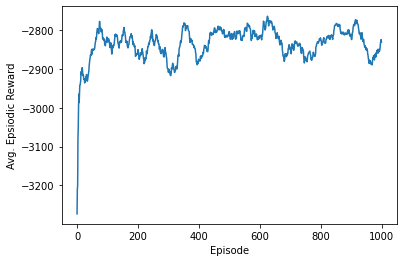

In [10]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

## Evaluate policy

In [13]:
file_path = "CMAPSSData/train_FD002.txt"
num_settings = 3
num_sensors = 21
num_units = 40
prev_step_units = 240
step = ""

# Test data
t_data = DataPrep(file=file_path,
                num_settings=num_settings, 
                num_sensors=num_sensors, 
                num_units=num_units, 
                prev_step_units=prev_step_units,
                step=step,
                normalization_type="01")

test_df = t_data.ReadData()

In [14]:
len(test_df)

4364

In [15]:
test_df.head()

,Unit,NormTime,OpSetting1,OpSetting2,OpSetting3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor12,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21
0,241,1.000000,0.595099,0.736342,0.0,0.238089,0.010311,0.051374,0.010265,0.293184,...,0.088637,0.001434,0.060915,0.915211,0.0,0.031915,0.000000,0.0,0.136864,0.142847
1,241,0.994536,0.999976,0.997625,1.0,0.000000,0.128061,0.287673,0.226278,0.000000,...,0.003430,0.993245,0.573673,0.384477,0.0,0.287234,0.627907,1.0,0.012036,0.008898
2,241,0.989071,0.000038,0.001188,1.0,1.000000,0.985454,0.937133,0.936451,1.000000,...,0.997714,0.993493,0.709531,0.042082,1.0,0.946809,1.000000,1.0,0.986589,0.985913
3,241,0.983607,0.833151,0.998694,1.0,0.060269,0.183392,0.326677,0.227443,0.146592,...,0.134517,0.993410,0.532670,0.344712,0.0,0.308511,0.651163,1.0,0.151994,0.153282
4,241,0.978142,0.476128,0.831354,1.0,0.626985,0.661941,0.648225,0.551313,0.507937,...,0.471915,0.993769,0.529251,0.333493,0.0,0.617021,0.864693,1.0,0.486245,0.496670


In [16]:
# List of engine lifetimes
engine_lives = test_df.groupby(test_df['Unit']).size()
engine_lives = engine_lives.tolist()
num_engines = len(engine_lives)

print(engine_lives, num_engines)

[183, 273, 230, 128, 253, 194, 197, 234, 202, 184, 266, 135, 149, 260, 340, 163, 309, 143, 205, 316] 20


In [17]:
# Load decoder
vae = VAE(latent_dim=1,image_size=25)

##########################################
env_config = {
    "df": test_df,
    "timestep": 0,
    "obs_size": num_settings+num_sensors+1,
    "engines": num_engines,
    "engine_lives": engine_lives, 
    "decoder_model": vae.load_models(),
}

print("env_config: ", env_config)

INFO:tensorflow:Assets written to: ram://908d496a-63d6-46ca-b680-35f9e31feedb/assets
env_config:  {'df':       Unit  NormTime  OpSetting1  OpSetting2  OpSetting3   Sensor1   Sensor2  \
0      241  1.000000    0.595099    0.736342         0.0  0.238089  0.010311   
1      241  0.994536    0.999976    0.997625         1.0  0.000000  0.128061   
2      241  0.989071    0.000038    0.001188         1.0  1.000000  0.985454   
3      241  0.983607    0.833151    0.998694         1.0  0.060269  0.183392   
4      241  0.978142    0.476128    0.831354         1.0  0.626985  0.661941   
...    ...       ...         ...         ...         ...       ...       ...   
4359   260  0.015823    0.476188    0.831354         1.0  0.626985  0.674461   
4360   260  0.012658    0.238102    0.298100         1.0  0.597937  0.647026   
4361   260  0.009494    0.595222    0.736342         0.0  0.238089  0.017952   
4362   260  0.006329    0.595203    0.738717         0.0  0.238089  0.021267   
4363   260  0.0

In [18]:
env = CMAPSSEnv(**env_config)

In [20]:
target_actor.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense_9 (Dense)             (None, 256)               6656      
                                                                 
 dense_10 (Dense)            (None, 256)               65792     
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                                 
 tf.math.multiply_1 (TFOpLam  (None, 1)                0         
 bda)                                                            
                                                                 
Total params: 72,705
Trainable params: 72,705
Non-trainable params: 0
_______________________________________________________

In [21]:
def trained_policy(state, noise_object):
    sampled_actions = tf.squeeze(target_actor(state, training=False))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.asarray([np.squeeze(legal_action)])

In [22]:
est_rul = []
state = tf.expand_dims(env.reset(), 0)
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.0) * np.ones(1))
action = target_actor(state, training=False).numpy()[0]
obs, _, _, _ = env.step(action)
est_rul.append(obs[0])

In [23]:
for t in range(1,engine_lives[0]):
    action = target_actor(state, training=False).numpy()[0]
    obs, _, _, _ = env.step(action)
    est_rul.append(obs[0])
    state = tf.reshape(tf.constant(obs.to_list()),[1,25])
    #print(rew, done)

In [24]:
est_rul

[1.0,
 0.994535519125683,
 0.9890710382513661,
 0.9836065573770492,
 0.9781420765027322,
 0.9726775956284153,
 0.9672131147540983,
 0.9617486338797814,
 0.9562841530054644,
 0.9508196721311475,
 0.9453551912568307,
 0.9398907103825137,
 0.9344262295081968,
 0.9289617486338798,
 0.9234972677595629,
 0.9180327868852459,
 0.912568306010929,
 0.907103825136612,
 0.9016393442622951,
 0.8961748633879781,
 0.8907103825136612,
 0.8852459016393442,
 0.8797814207650273,
 0.8743169398907104,
 0.8688524590163934,
 0.8633879781420765,
 0.8579234972677595,
 0.8524590163934426,
 0.8469945355191257,
 0.8415300546448088,
 0.8360655737704918,
 0.8306010928961749,
 0.825136612021858,
 0.819672131147541,
 0.8142076502732241,
 0.8087431693989071,
 0.8032786885245902,
 0.7978142076502732,
 0.7923497267759563,
 0.7868852459016393,
 0.7814207650273224,
 0.7759562841530054,
 0.7704918032786885,
 0.7650273224043715,
 0.7595628415300546,
 0.7540983606557377,
 0.7486338797814208,
 0.7431693989071039,
 0.737704918

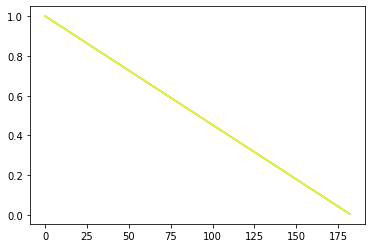

In [26]:
import matplotlib.pyplot as plt

plt.plot(test_df['NormTime'][:engine_lives[0]])
plt.plot(est_rul, color='yellow')
plt.show()